This subject of this project is the housing crisis in Ireland.
- Is this also the case in other countries within the UK & Ireland?
- Is housing increasing or decreasing in line with population growth?
- Will current trends in houses being built be able to accomodate the population over time?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import glob
from copy import deepcopy

In [3]:
import requests
import json
import xml.etree.ElementTree as ET

In [4]:
plt.rcParams['figure.figsize'] = [12, 8]

# Data Ingestion

## IE Data First
This will later be replaced by mongodb calls using json versions of this data.

In [5]:
# https://data.gov.ie/dataset/ndq01-new-dwelling-completions/resource/8fdc8f87-88ca-43f7-aa16-dbc3a52cacde
df_ie_ndq1_orig = pd.read_csv('./datasets/ie/NDQ01.csv')

# https://data.gov.ie/dataset/ndq03-new-dwelling-completions/resource/45701f7f-1192-406f-980f-a8ee23862147
df_ie_ndq3_orig = pd.read_csv('./datasets/ie/NDQ03.csv')

# https://data.gov.ie/dataset/ndq05-new-dwelling-completion/resource/108d82d0-43f1-4574-9e47-bb54f078fd84
df_ie_ndq5_orig = pd.read_csv('./datasets/ie/NDQ05.csv')

# https://data.gov.ie/dataset/ndq06-new-dwelling-completion/resource/0b5041bb-9f52-4b54-8c8d-0000306e74e2
df_ie_ndq6_orig = pd.read_csv('./datasets/ie/NDQ06.csv')

# UK data

In [6]:
# https://www.ons.gov.uk/peoplepopulationandcommunity/housing/datasets/ukhousebuildingpermanentdwellingsstartedandcompleted
df_uk_con_output_orig = pd.read_excel('./datasets/uk/outputukhousebuilding.xlsx')

# Population data

# Data Cleansing & Preparation

# IE functions

In [7]:
def extract_year_and_qtr(df, qtr_col_name):
    """
    Add docstring
    """
    
    df['year'] = df[qtr_col_name].str[:4].astype('int64')
    df['qtr'] = df[qtr_col_name].str[-2:]
    return df

## IE Data

In [8]:
df_ie_ndq1 = deepcopy(df_ie_ndq1_orig)

In [9]:
df_ie_ndq1.head()

STATISTIC           STATISTIC Label  TLIST(Q1) Quarter C02342V02816  \
0     NDQ01  New Dwelling Completions      20111  2011Q1           06   
1     NDQ01  New Dwelling Completions      20111  2011Q1           07   
2     NDQ01  New Dwelling Completions      20111  2011Q1           08   
3     NDQ01  New Dwelling Completions      20111  2011Q1            -   
4     NDQ01  New Dwelling Completions      20112  2011Q2           06   

     Type of House    UNIT  VALUE  
0     Single house  Number   1156  
1     Scheme house  Number    447  
2        Apartment  Number    272  
3  All house types  Number   1875  
4     Single house  Number   1194

In [10]:
df_ie_ndq1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   STATISTIC        392 non-null    object
 1   STATISTIC Label  392 non-null    object
 2   TLIST(Q1)        392 non-null    int64 
 3   Quarter          392 non-null    object
 4   C02342V02816     392 non-null    object
 5   Type of House    392 non-null    object
 6   UNIT             392 non-null    object
 7   VALUE            392 non-null    int64 
dtypes: int64(2), object(6)
memory usage: 24.6+ KB


In [11]:
df_ie_ndq1 = extract_year_and_qtr(df_ie_ndq1, 'Quarter')

In [12]:
df_ie_ndq1['STATISTIC Label'].unique()

array(['New Dwelling Completions',
       'Seasonally Adjusted New Dwelling Completions'], dtype=object)

In [13]:
# Statistic & Statistic Label represent the same data, so we can drop STATISTC and keep the label
df_ie_ndq1.pivot_table(index='STATISTIC Label',  columns='STATISTIC', values='VALUE', aggfunc='sum')

STATISTIC                                        NDQ01  NDQ01C02
STATISTIC Label                                                 
New Dwelling Completions                      339994.0       NaN
Seasonally Adjusted New Dwelling Completions       NaN  340507.0

<AxesSubplot: xlabel='year', ylabel='VALUE'>

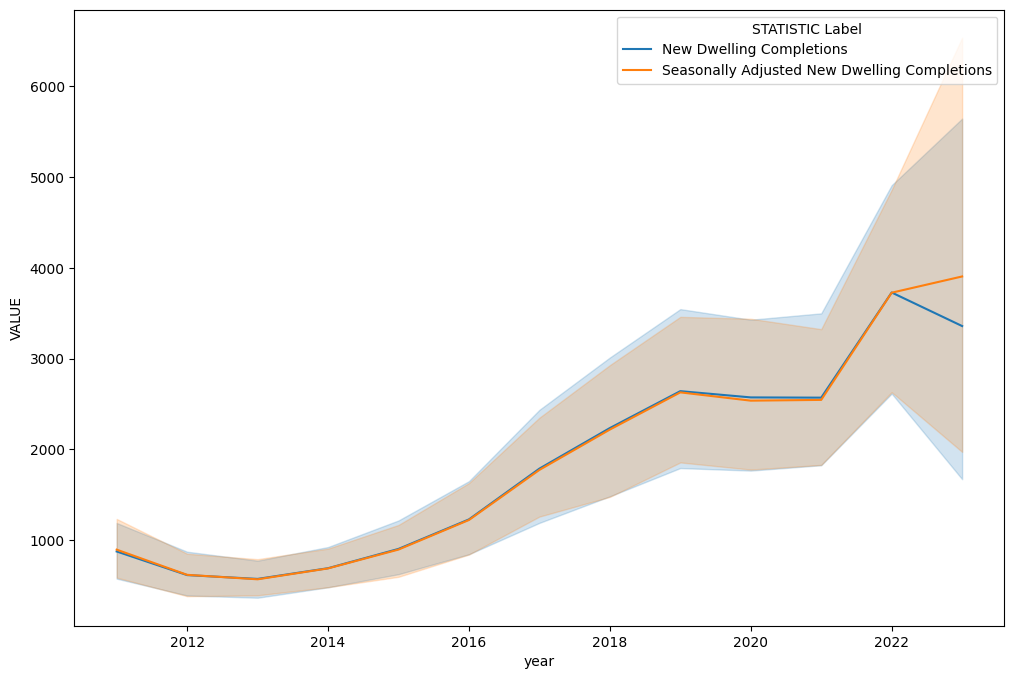

In [14]:
sns.lineplot(data=df_ie_ndq1, x='year', y='VALUE', hue='STATISTIC Label')

In [15]:
df_ie_ndq1.groupby(['STATISTIC Label'])['VALUE'].sum()

STATISTIC Label
New Dwelling Completions                        339994
Seasonally Adjusted New Dwelling Completions    340507
Name: VALUE, dtype: int64

In [16]:
df_ie_ndq1 = df_ie_ndq1[df_ie_ndq1['STATISTIC Label'] == 'New Dwelling Completions']

In [17]:
# Type of House is mapped to C02342V02816, so we can drop C02342V02816.
df_ie_ndq1.pivot_table(index='Type of House',  columns='C02342V02816', values='VALUE', aggfunc='sum', fill_value=0)

C02342V02816          -     06     07     08
Type of House                               
All house types  169997      0      0      0
Apartment             0      0      0  32826
Scheme house          0      0  85622      0
Single house          0  51549      0      0

In [18]:
# The sum of Apartment, Scheme house and Single house equals All house types
df_ie_ndq1[df_ie_ndq1['Type of House']!='All house types'].pivot_table(index='Type of House',  columns='C02342V02816', values='VALUE', aggfunc='sum', fill_value=0).sum().sum()

169997

In [19]:
df_ie_ndq1['type_comp'] = df_ie_ndq1['Type of House'].apply(lambda x: 'All' if x != "All house types" else x)

In [20]:
df_ndq1_temp = df_ie_ndq1.pivot_table(index='Quarter',  columns='type_comp', values='VALUE', aggfunc='sum', fill_value=0)
df_ndq1_temp.head()

type_comp   All  All house types
Quarter                         
2011Q1     1875             1875
2011Q2     1791             1791
2011Q3     1687             1687
2011Q4     1641             1641
2012Q1     1131             1131

In [21]:
df_ndq1_temp['diff'] = df_ndq1_temp['All'] - df_ndq1_temp['All house types']
df_ndq1_temp[df_ndq1_temp['diff'] != 0]

Empty DataFrame
Columns: [All, All house types, diff]
Index: []

In [22]:
assert((df_ndq1_temp['All'] == df_ndq1_temp['All house types']).all())

In [23]:
# UNIT is an unnecessary column as there is just a single value 'Number'.
df_ie_ndq1.pivot_table(index='UNIT',  columns='Type of House', values='VALUE', aggfunc='sum', fill_value=0)

Type of House  All house types  Apartment  Scheme house  Single house
UNIT                                                                 
Number                  169997      32826         85622         51549

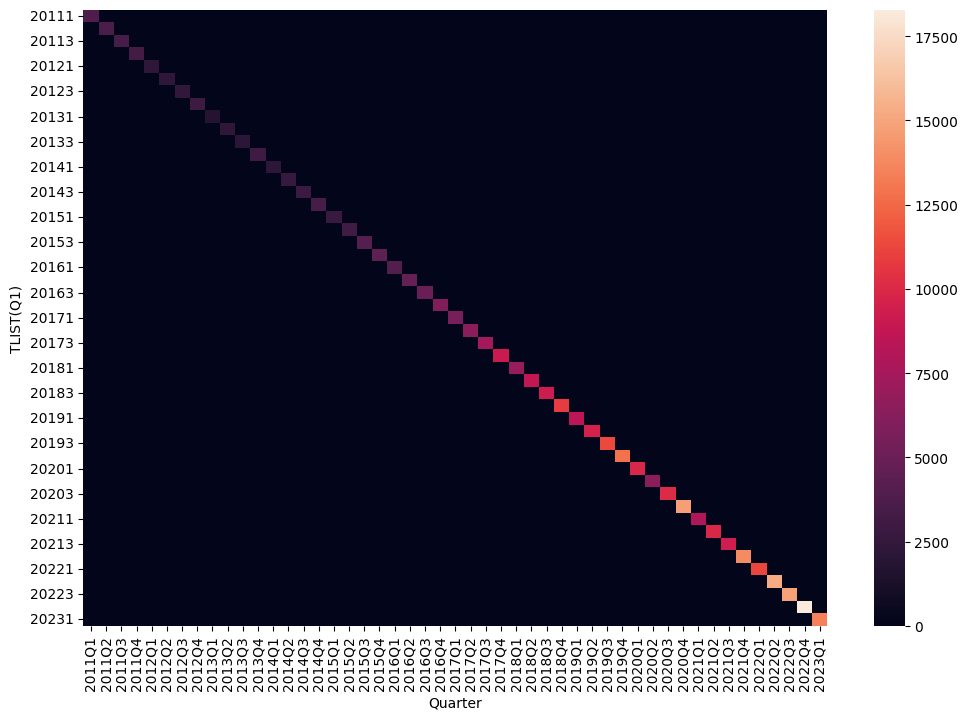

In [24]:
# TLIST(Q1) appears to be the same as Quarter
df_qtr_pivot = df_ie_ndq1.pivot_table(index='TLIST(Q1)',  columns='Quarter', values='VALUE', aggfunc='sum', fill_value=0)
sns.heatmap(df_qtr_pivot)
plt.show()

In [25]:
# Test that all the values in TLIST(Q1) are the same as in Quarter but with an added Q in the second last position
assert((df_ie_ndq1['Quarter'].str.replace('Q', '').astype('str') == df_ie_ndq1['TLIST(Q1)'].astype('str')).all())

In [26]:
list_cols_to_drop = ['STATISTIC', 'TLIST(Q1)', 'C02342V02816', 'UNIT', 'type_comp']

In [27]:
df_ie_ndq1_clean = df_ie_ndq1.drop(list_cols_to_drop, axis=1)

In [28]:
df_ie_ndq1_clean.head()

STATISTIC Label Quarter    Type of House  VALUE  year qtr
0  New Dwelling Completions  2011Q1     Single house   1156  2011  Q1
1  New Dwelling Completions  2011Q1     Scheme house    447  2011  Q1
2  New Dwelling Completions  2011Q1        Apartment    272  2011  Q1
3  New Dwelling Completions  2011Q1  All house types   1875  2011  Q1
4  New Dwelling Completions  2011Q2     Single house   1194  2011  Q2

What is the difference between New & Seasonally adjusted?  
Looks like seasonally adjusted has some applied logic where New is the raw numbers.  
- For now focus on new until I can justify the selection.

In [29]:
# I don't think I'll end up needing this but keep it for now and decide when joining the dataframes.
df_ie_ndq1_pivot = df_ie_ndq1_clean.pivot_table(index=['STATISTIC Label', 'Quarter', 'year'], columns='Type of House', values='VALUE', aggfunc='sum', fill_value=0).reset_index()

In [30]:
df_ie_ndq1_pivot.head()

Type of House           STATISTIC Label Quarter  year  All house types  \
0              New Dwelling Completions  2011Q1  2011             1875   
1              New Dwelling Completions  2011Q2  2011             1791   
2              New Dwelling Completions  2011Q3  2011             1687   
3              New Dwelling Completions  2011Q4  2011             1641   
4              New Dwelling Completions  2012Q1  2012             1131   

Type of House  Apartment  Scheme house  Single house  
0                    272           447          1156  
1                    217           380          1194  
2                    185           305          1197  
3                    148           226          1267  
4                    123           211           797

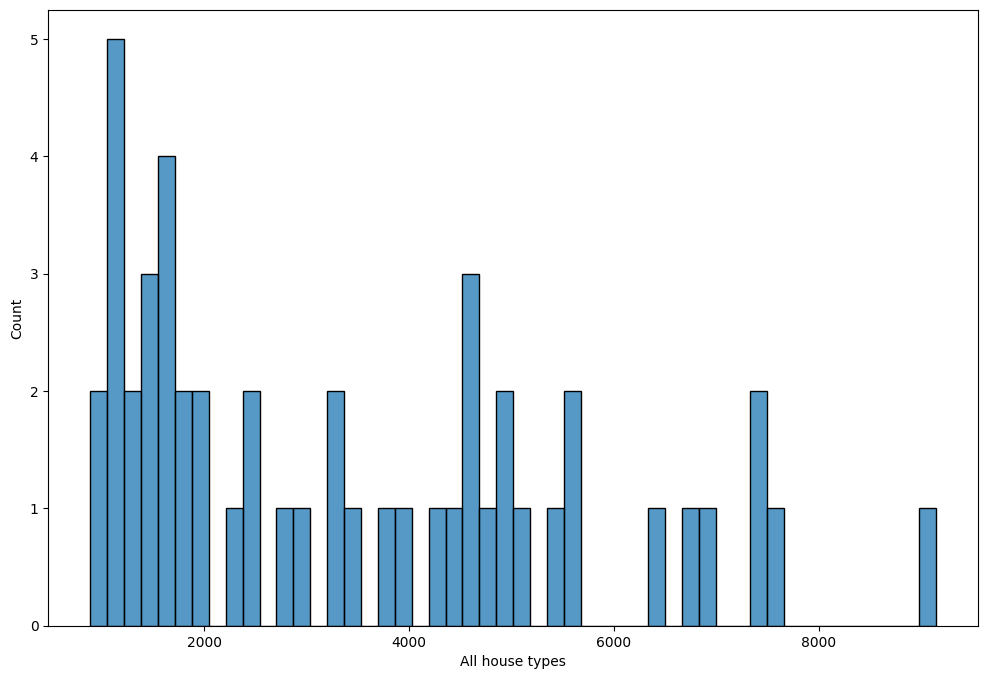

In [31]:
sns.histplot(data=df_ie_ndq1_pivot, x='All house types', bins=50)
plt.show()

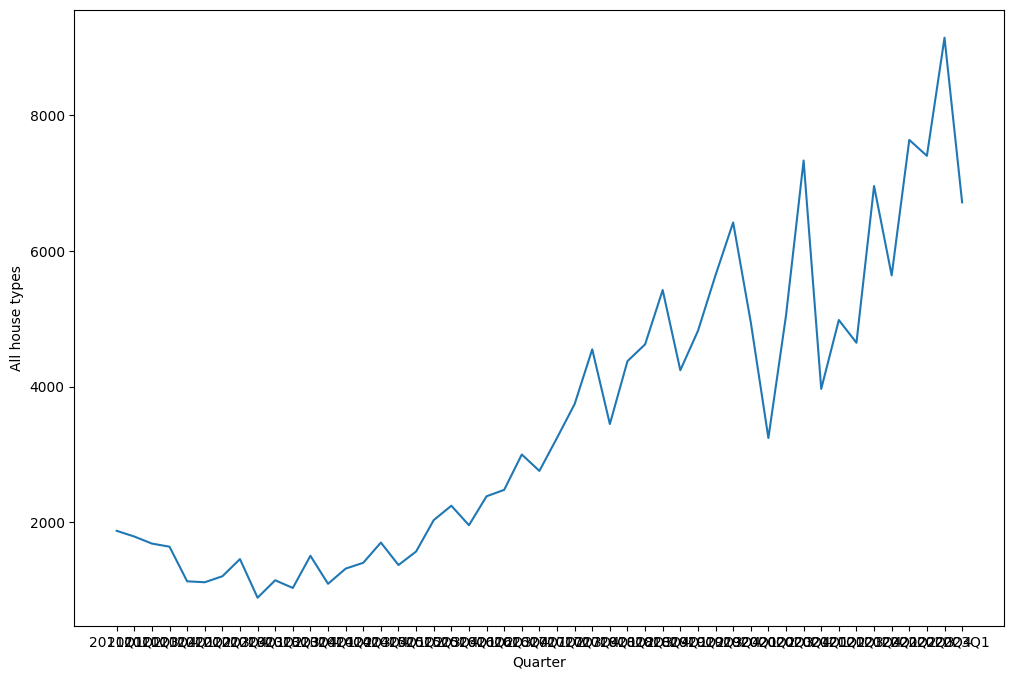

In [32]:
sns.lineplot(data=df_ie_ndq1_pivot, x='Quarter', y='All house types')
plt.show()

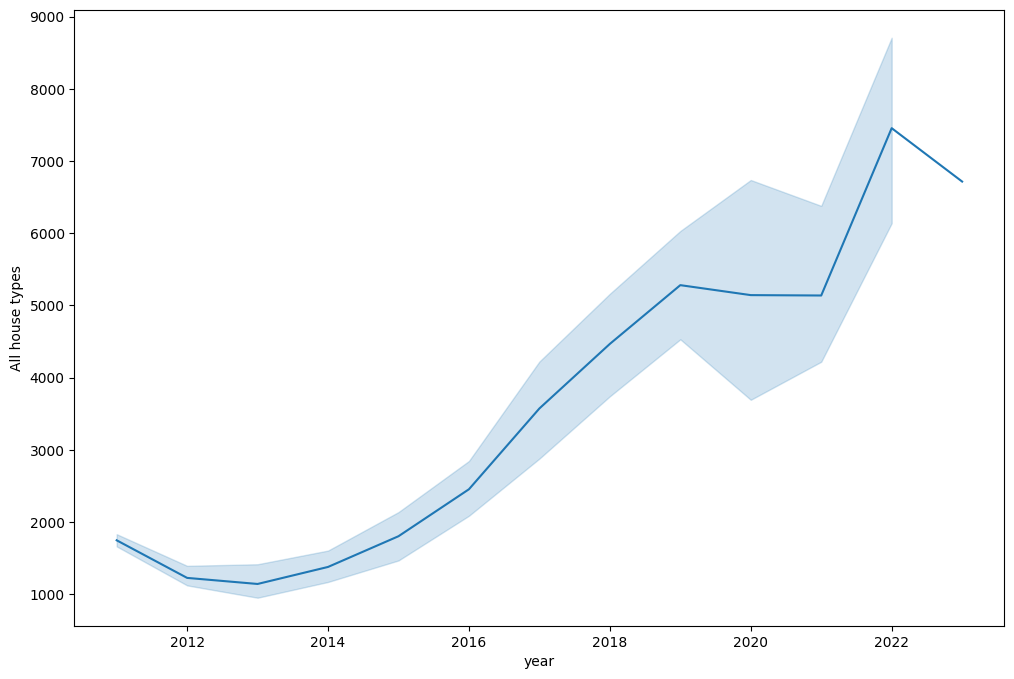

In [33]:
sns.lineplot(data=df_ie_ndq1_pivot, x='year', y='All house types')
plt.show()

Scheme houses took a sharp drop from 2019 to 2021 then a shrap rise and another sharp drop.  
- Could this be due to missing data or just is it a reflection of reality?
- Correction, this is due to COVID. (https://www.irishtimes.com/business/construction/over-20-000-new-homes-completed-in-2020-despite-covid-disruption-1.4476058)   
The downturn in Q2 & Q3 was across all segments but apartments recovered in Q4.  

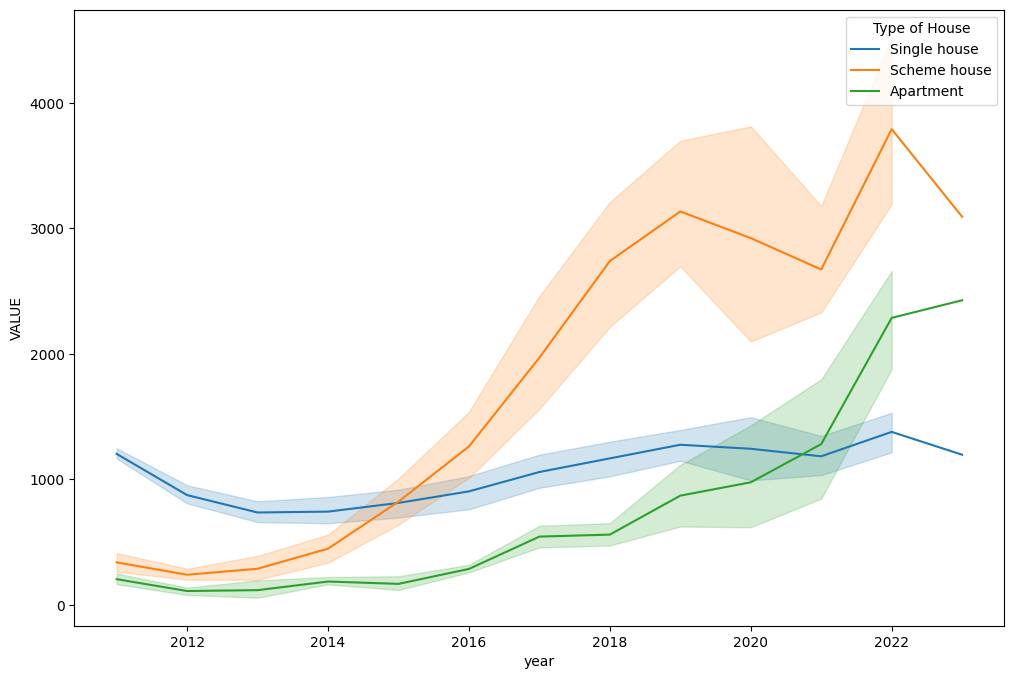

In [34]:
sns.lineplot(data=df_ie_ndq1_clean[df_ie_ndq1_clean['Type of House']!= 'All house types'],
                                                    x='year', y='VALUE', hue='Type of House')
plt.show()

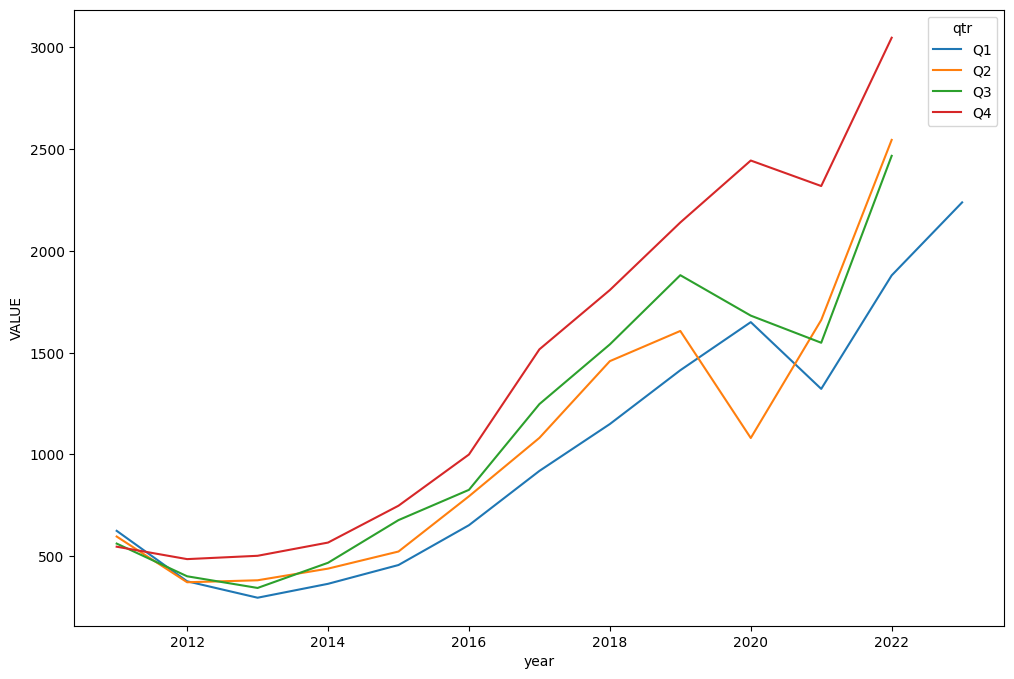

In [35]:
sns.lineplot(data=df_ie_ndq1_clean[df_ie_ndq1_clean['Type of House']!= 'All house types'],
                                                    x='year', y='VALUE', hue='qtr', errorbar=None)
plt.show()

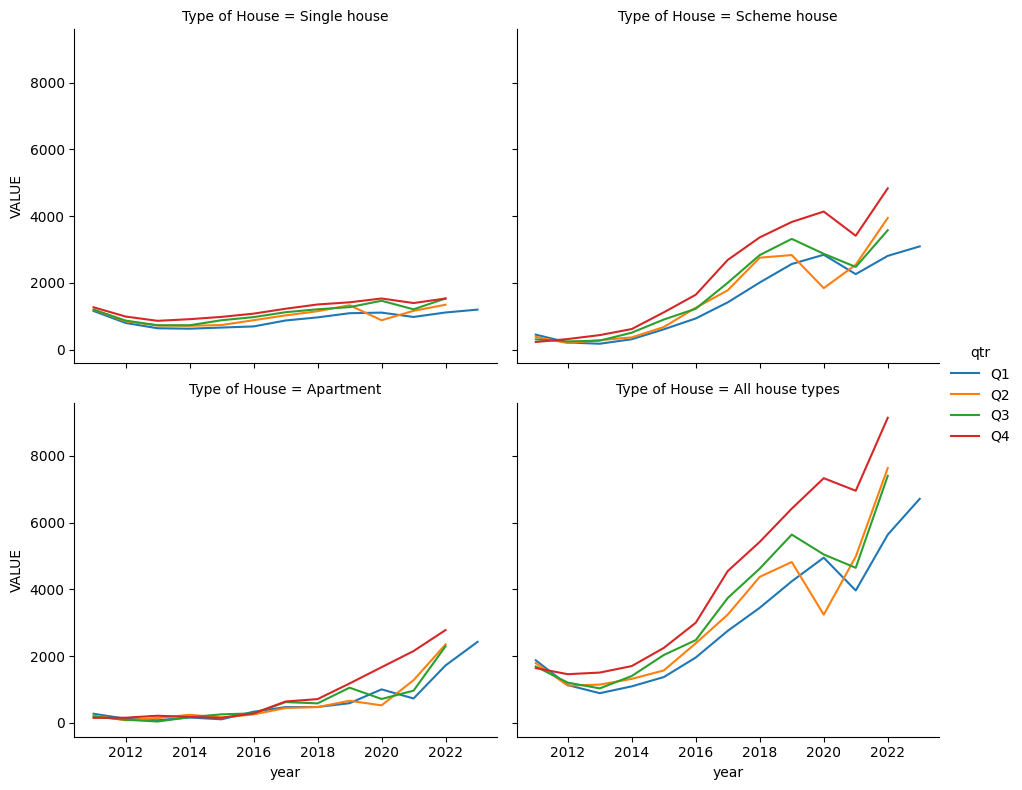

In [36]:
sns.relplot(data=df_ie_ndq1_clean, kind='line', x='year', y='VALUE', hue='qtr',
            col='Type of House', col_wrap=2, height=4, aspect=1.2, legend=True)
plt.show()

In [37]:
df_ndq1_house_totals = df_ie_ndq1_clean.groupby(['Type of House'])['VALUE'].sum()

## IE DF no.2

In [38]:
df_ie_ndq3 = deepcopy(df_ie_ndq3_orig)

In [39]:
df_ie_ndq3.head(10)

STATISTIC           STATISTIC Label  TLIST(Q1) Quarter C02342V02816  \
0     NDQ03  New Dwelling Completions      20111  2011Q1            -   
1     NDQ03  New Dwelling Completions      20111  2011Q1            -   
2     NDQ03  New Dwelling Completions      20111  2011Q1           06   
3     NDQ03  New Dwelling Completions      20111  2011Q1           06   
4     NDQ03  New Dwelling Completions      20111  2011Q1           07   
5     NDQ03  New Dwelling Completions      20111  2011Q1           07   
6     NDQ03  New Dwelling Completions      20111  2011Q1           08   
7     NDQ03  New Dwelling Completions      20111  2011Q1           08   
8     NDQ03  New Dwelling Completions      20112  2011Q2            -   
9     NDQ03  New Dwelling Completions      20112  2011Q2            -   

     Type of House  C02106V02545 Urban and Rural    UNIT  VALUE  
0  All house types             1     Urban areas  Number    841  
1  All house types             5     Rural areas  Number   1033  
2     Single house             1     Urban areas  Number    152  
3     Single house             5     Rural areas  Number   1004  
4     Scheme house             1     Urban areas  Number    422  
5     Scheme house             5     Rural areas  Number     25  
6        Apartment             1     Urban areas  Number    267  
7        Apartment             5     Rural areas  Number      4  
8  All house types             1     Urban areas  Number    706  
9  All house types             5     Rural areas  Number   1081

In [40]:
df_ie_ndq3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   STATISTIC        392 non-null    object
 1   STATISTIC Label  392 non-null    object
 2   TLIST(Q1)        392 non-null    int64 
 3   Quarter          392 non-null    object
 4   C02342V02816     392 non-null    object
 5   Type of House    392 non-null    object
 6   C02106V02545     392 non-null    int64 
 7   Urban and Rural  392 non-null    object
 8   UNIT             392 non-null    object
 9   VALUE            392 non-null    int64 
dtypes: int64(3), object(7)
memory usage: 30.8+ KB


In [41]:
df_ie_ndq3 = extract_year_and_qtr(df_ie_ndq3, 'Quarter')

In [42]:
# Check if all house types is equal to the sum of urban and rural areas
df_ie_ndq3['type_comp'] = df_ie_ndq3['Type of House'].apply(lambda x: 'All' if x != "All house types" else x)

In [43]:
df_ndq3_temp = df_ie_ndq3.pivot_table(index=['Quarter', 'Urban and Rural'],  columns='type_comp', values='VALUE', aggfunc='sum', fill_value=0)
df_ndq3_temp.head()

type_comp                 All  All house types
Quarter Urban and Rural                       
2011Q1  Rural areas      1033             1033
        Urban areas       841              841
2011Q2  Rural areas      1081             1081
        Urban areas       706              706
2011Q3  Rural areas      1085             1085

In [44]:
df_ndq3_temp['diff'] = df_ndq3_temp['All'] - df_ndq3_temp['All house types']
df_ndq3_temp

type_comp                 All  All house types  diff
Quarter Urban and Rural                             
2011Q1  Rural areas      1033             1033     0
        Urban areas       841              841     0
2011Q2  Rural areas      1081             1081     0
        Urban areas       706              706     0
2011Q3  Rural areas      1085             1085     0
...                       ...              ...   ...
2022Q3  Urban areas      6087             6087     0
2022Q4  Rural areas      1339             1339     0
        Urban areas      7804             7804     0
2023Q1  Rural areas       967              967     0
        Urban areas      5749             5749     0

[98 rows x 3 columns]

In [126]:
df_ndq3_temp[df_ndq3_temp['diff']==0]

Empty DataFrame
Columns: [ndq1, ndq3, diff, diff %]
Index: []

In [45]:
# Totals are equal
df_ie_ndq3.pivot_table(index='UNIT',  columns='type_comp', values='VALUE', aggfunc='sum', fill_value=0)

type_comp     All  All house types
UNIT                              
Number     169985           169985

In [46]:
df_ndq3_house_totals = df_ie_ndq3.groupby(['Type of House'])['VALUE'].sum()

In [47]:
# Approx half of each house type from ndq1 is included in ndq3 - including totals.
df_ndq3_temp = pd.concat([df_ndq1_house_totals, df_ndq3_house_totals], axis=1)
df_ndq3_temp.columns = ['ndq1', 'ndq3']
df_ndq3_temp['diff'] = df_ndq3_temp['ndq1'] - df_ndq3_temp['ndq3']
df_ndq3_temp['diff %'] = df_ndq3_temp['diff'] / df_ndq3_temp['ndq1']
print(df_ndq3_temp)

                   ndq1    ndq3  diff    diff %
Type of House                                  
All house types  169997  169985    12  0.000071
Apartment         32826   32819     7  0.000213
Scheme house      85622   85621     1  0.000012
Single house      51549   51545     4  0.000078


In [48]:
# Urban and Rural is mapped to C02106V02545, so we can drop C02106V02545.
df_ie_ndq3.pivot_table(index='Urban and Rural',  columns='C02106V02545', values='VALUE', aggfunc='sum', fill_value=0)

C02106V02545          1      5
Urban and Rural               
Rural areas           0  87864
Urban areas      252106      0

In [49]:
# Add C02106V02545 to the existing drop_cols list as the other columns are also present.
list_cols_to_drop.append('C02106V02545')

In [50]:
df_ie_ndq3_clean = df_ie_ndq3.drop(list_cols_to_drop, axis=1)

In [52]:
df_ie_ndq3_clean.head()

STATISTIC Label Quarter    Type of House Urban and Rural  VALUE  \
0  New Dwelling Completions  2011Q1  All house types     Urban areas    841   
1  New Dwelling Completions  2011Q1  All house types     Rural areas   1033   
2  New Dwelling Completions  2011Q1     Single house     Urban areas    152   
3  New Dwelling Completions  2011Q1     Single house     Rural areas   1004   
4  New Dwelling Completions  2011Q1     Scheme house     Urban areas    422   

   year qtr  
0  2011  Q1  
1  2011  Q1  
2  2011  Q1  
3  2011  Q1  
4  2011  Q1

In [159]:
df_ie_ndq3_house_pivot = df_ie_ndq3_clean.pivot_table(index=['STATISTIC Label', 'Quarter', 'year', 'qtr'], columns=['Urban and Rural', 'Type of House'], values='VALUE', aggfunc='sum', fill_value=0).reset_index()




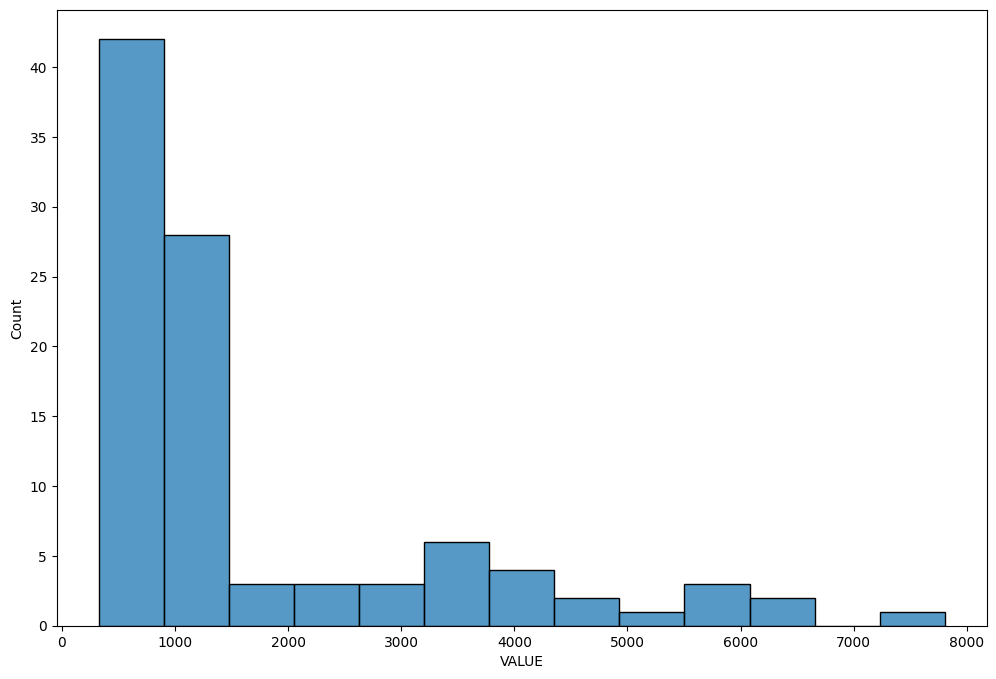

In [54]:
sns.histplot(data=df_ie_ndq3_clean[df_ie_ndq3_clean['Type of House'] == 'All house types'], x='VALUE')
plt.show()

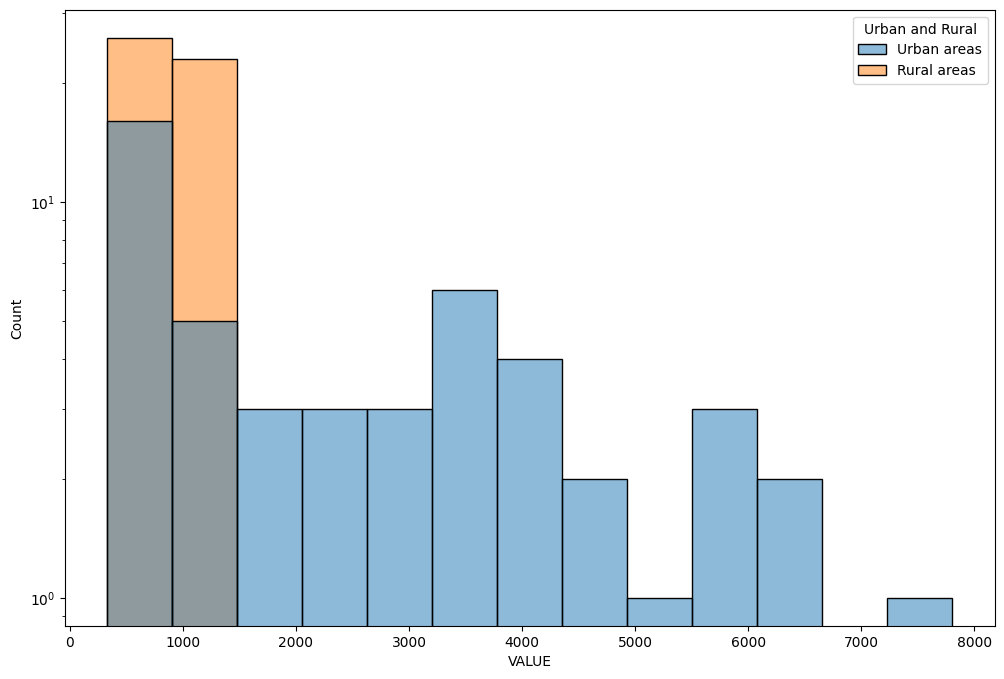

In [55]:
hp = sns.histplot(data=df_ie_ndq3_clean[df_ie_ndq3_clean['Type of House'] == 'All house types'], 
             x='VALUE', hue='Urban and Rural', alpha=0.5)
hp.set_yscale('log')
plt.show()

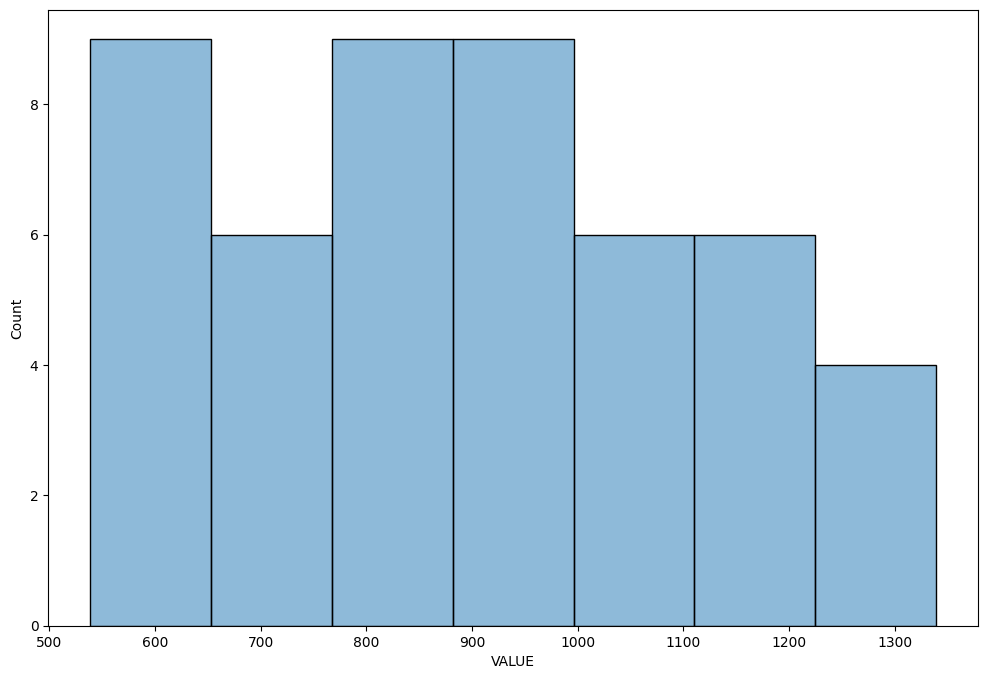

In [56]:
rural_df = df_ie_ndq3_clean[(df_ie_ndq3_clean['Type of House']=='All house types') & (df_ie_ndq3_clean['Urban and Rural']=='Rural areas')]
sns.histplot(data=rural_df, x='VALUE', alpha=0.5)
hp.set_yscale('log')

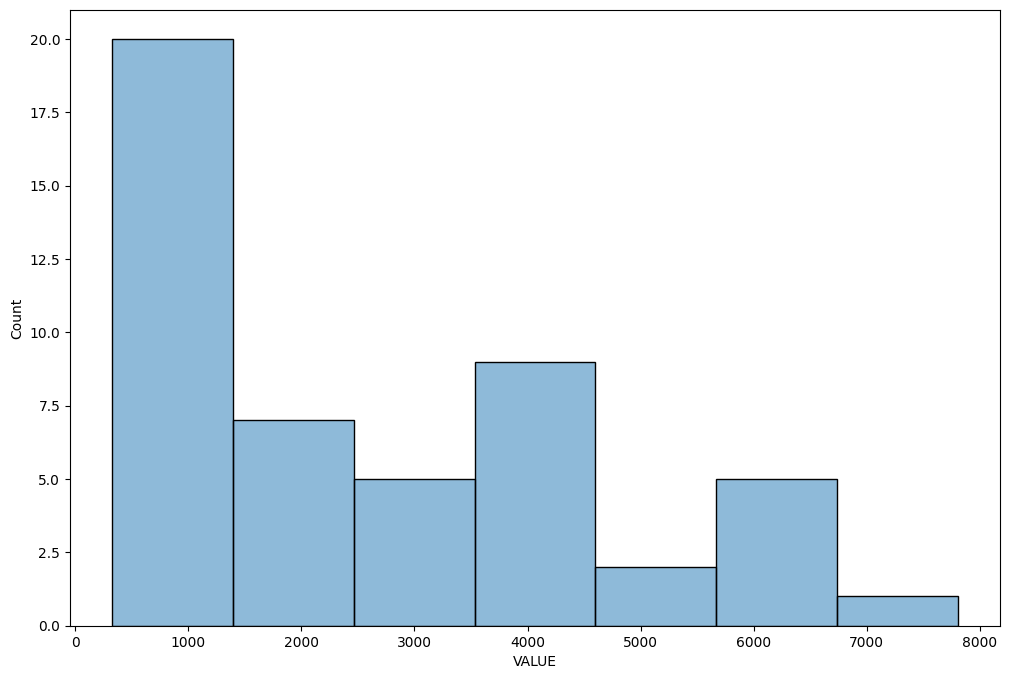

In [57]:
urban_df = df_ie_ndq3_clean[(df_ie_ndq3_clean['Type of House']=='All house types') & (df_ie_ndq3_clean['Urban and Rural']=='Urban areas')]
sns.histplot(data=urban_df, x='VALUE', alpha=0.5)
hp.set_yscale('log')

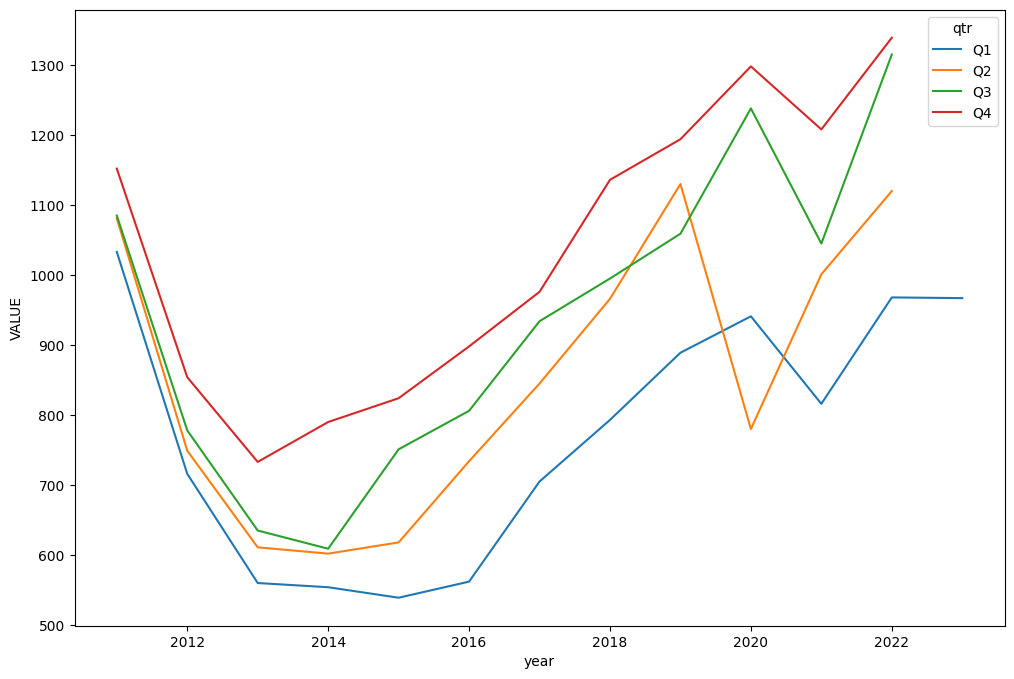

In [58]:
sns.lineplot(data=rural_df, x='year', y='VALUE', hue='qtr')
plt.show()

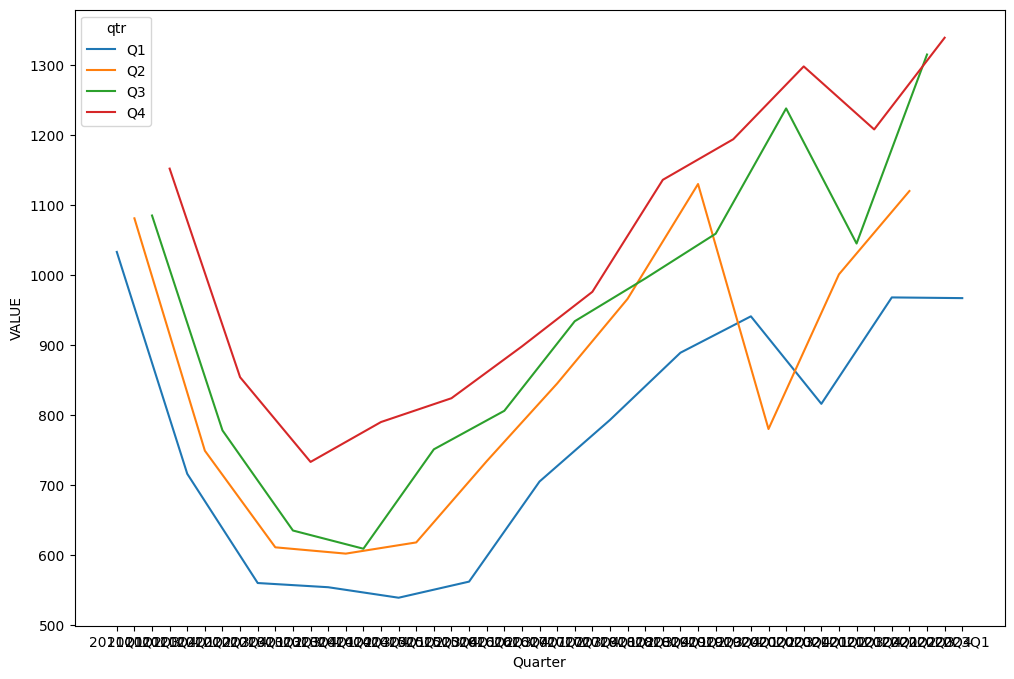

In [59]:
sns.lineplot(data=rural_df, x='Quarter', y='VALUE', hue='qtr')
plt.show()

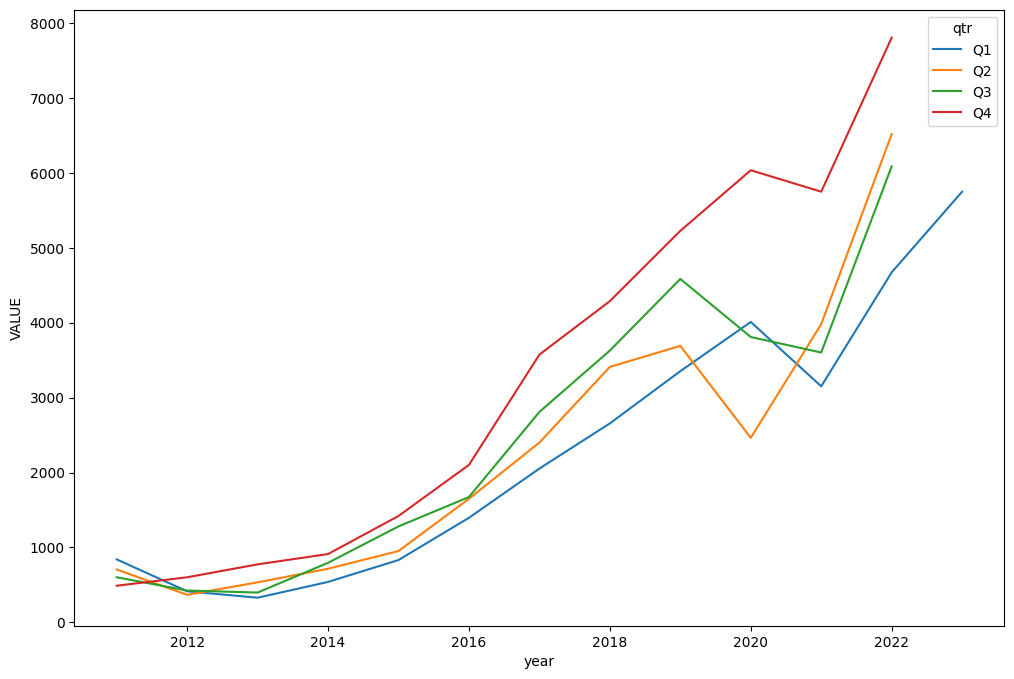

In [60]:
sns.lineplot(data=urban_df, x='year', y='VALUE', hue='qtr')
plt.show()

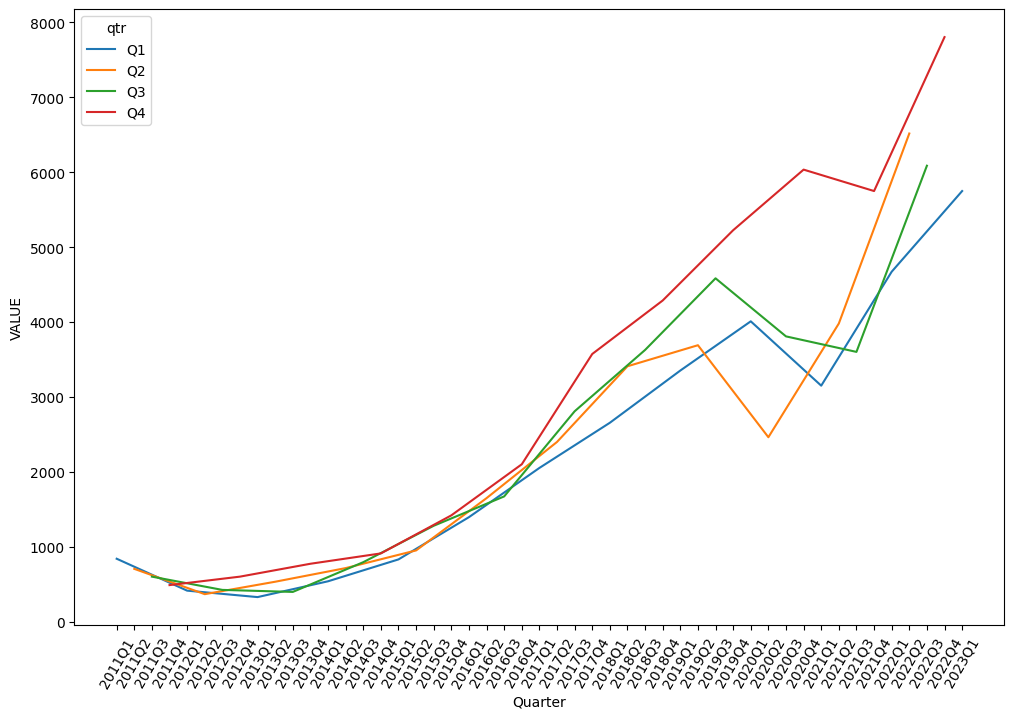

In [61]:
sns.lineplot(data=urban_df, x='Quarter', y='VALUE', hue='qtr')
plt.xticks(rotation=60)

plt.show()

## IE DF no.3

In [62]:
dict_county_mapping = {'Dún Laoghaire Rathdown':"Dublin", 'Fingal':"Dublin", 'South Dublin':"Dublin"}

In [63]:
def get_county_province_mapping():
    # Create a dictionary to map county to province using a table from Wikipedia.
    # Reading the html populates the list 'tables' with all tables parsed from the HTML.
    # A manual review of tables is necessary to ensure that the table is correct.
    # TODO - add error checking or write to file and read the csv each time this run/
    tables = pd.read_html("https://en.wikipedia.org/wiki/Counties_of_Ireland")
    ie_county_details = tables[3]
    ie_county_details.head()
    # ie_county_details.to_csv('./datasets/county_province_names.csv')
    # Select relevant columns.
    df_county_province_mapping = ie_county_details[['County', 'Province']]

    # Remove trailing characters from the County names.
    df_county_province_mapping.loc[:,'County'] = df_county_province_mapping['County'].str.replace("\[[A-Za-z]\]", "", regex=True)

    # Adjust Londonderry to Derry to match other datasources.
    df_county_province_mapping.loc[:,'County'] = df_county_province_mapping['County'].str.replace("Londonderry", "Derry")

    # Change all column headers to lower case.
    df_county_province_mapping.columns = [col.lower() for col in df_county_province_mapping.columns]
    
    return df_county_province_mapping

In [64]:
def map_county_and_province(df, mapping_df):
    df = pd.merge(left=df, right=mapping_df, on='county', how='left')
    return df

In [65]:
def rollup_county_values(df):
        col_names = [col for col in df.columns if col != 'VALUE']
        df = df.groupby(col_names)['VALUE'].sum().reset_index()
        return df

In [66]:
def county_mapping(df, mapping_dict):
    """
    Insert docstring
    
    """
    df['CC_name'] = df['Local Authority'].str.split(' C', n=1).str[0]
    df['county'] = df['CC_name'].str.strip().replace(mapping_dict)
    df = df.drop(['CC_name', 'Local Authority'], axis=1)
    county_mapping_df = get_county_province_mapping()
    df = rollup_county_values(df)
    df = map_county_and_province(df, county_mapping_df)
    return df

In [67]:
df_ie_ndq5 = deepcopy(df_ie_ndq5_orig)

In [68]:
df_ie_ndq5.head()

STATISTIC          STATISTIC Label  TLIST(Q1) Quarter  \
0     NDQ05  New Dwelling Completion      20111  2011Q1   
1     NDQ05  New Dwelling Completion      20111  2011Q1   
2     NDQ05  New Dwelling Completion      20111  2011Q1   
3     NDQ05  New Dwelling Completion      20111  2011Q1   
4     NDQ05  New Dwelling Completion      20111  2011Q1   

                           C03789V04537       Local Authority    UNIT  VALUE  
0                                     -               Ireland  Number   1875  
1  2ae19629-1434-13a3-e055-000000000001     Cork City Council  Number     39  
2  2ae19629-14a2-13a3-e055-000000000001  Clare County Council  Number     52  
3  2ae19629-149d-13a3-e055-000000000001  Cavan County Council  Number     61  
4  2ae19629-14a3-13a3-e055-000000000001   Cork County Council  Number    168

In [69]:
df_ie_ndq5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1568 entries, 0 to 1567
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   STATISTIC        1568 non-null   object
 1   STATISTIC Label  1568 non-null   object
 2   TLIST(Q1)        1568 non-null   int64 
 3   Quarter          1568 non-null   object
 4   C03789V04537     1568 non-null   object
 5   Local Authority  1568 non-null   object
 6   UNIT             1568 non-null   object
 7   VALUE            1568 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 98.1+ KB


In [70]:
# For each value in C03789V04537, theres is one value for Local Authority, we can drop C03789V04537
df_ie_ndq5.groupby(['Local Authority'])['C03789V04537'].nunique()

Local Authority
Carlow County Council                    1
Cavan County Council                     1
Clare County Council                     1
Cork City Council                        1
Cork County Council                      1
Donegal County Council                   1
Dublin City Council                      1
Dún Laoghaire Rathdown County Council    1
Fingal County Council                    1
Galway City Council                      1
Galway County Council                    1
Ireland                                  1
Kerry County Council                     1
Kildare County Council                   1
Kilkenny County Council                  1
Laois County Council                     1
Leitrim County Council                   1
Limerick City & County Council           1
Longford County Council                  1
Louth County Council                     1
Mayo County Council                      1
Meath County Council                     1
Monaghan County Council               

In [71]:
df_ie_ndq5['auth_comp'] = df_ie_ndq5['Local Authority'].apply(lambda x: 'CC' if x != "Ireland" else x)

In [72]:
# Sum of all 
df_ie_ndq5.pivot_table(index='UNIT',  columns='auth_comp', values='VALUE', aggfunc='sum', fill_value=0)

auth_comp      CC  Ireland
UNIT                      
Number     169997   169997

In [73]:
# Compare the totals for each dataframe at the highest agg level in the data
ndq1_total = df_ie_ndq1[df_ie_ndq1['Type of House']=='All house types']['VALUE'].sum()
ndq3_total = df_ie_ndq3[df_ie_ndq3['Type of House']=='All house types']['VALUE'].sum()
ndq5_total = df_ie_ndq5[df_ie_ndq5['Local Authority']=='Ireland']['VALUE'].sum()

In [74]:
print(f"NDQ1: {ndq1_total}, NDQ3: {ndq3_total}, NDQ5: {ndq5_total}")
print(ndq1_total - ndq5_total)

NDQ1: 169997, NDQ3: 169985, NDQ5: 169997
0


https://www.citizensinformation.ie/en/government_in_ireland/national_government/local_and_regional_government/functions_of_local_authorities.html  
Differentiating between City and County council will have no material as it is not possible to determine if a specific council  type controls rural or urban planning

In [75]:
df_ie_ndq5['CC_name'] = df_ie_ndq5['Local Authority'].str.split(' C', n=1).str[0]
df_ie_ndq5.head(10)

STATISTIC          STATISTIC Label  TLIST(Q1) Quarter  \
0     NDQ05  New Dwelling Completion      20111  2011Q1   
1     NDQ05  New Dwelling Completion      20111  2011Q1   
2     NDQ05  New Dwelling Completion      20111  2011Q1   
3     NDQ05  New Dwelling Completion      20111  2011Q1   
4     NDQ05  New Dwelling Completion      20111  2011Q1   
5     NDQ05  New Dwelling Completion      20111  2011Q1   
6     NDQ05  New Dwelling Completion      20111  2011Q1   
7     NDQ05  New Dwelling Completion      20111  2011Q1   
8     NDQ05  New Dwelling Completion      20111  2011Q1   
9     NDQ05  New Dwelling Completion      20111  2011Q1   

                           C03789V04537  \
0                                     -   
1  2ae19629-1434-13a3-e055-000000000001   
2  2ae19629-14a2-13a3-e055-000000000001   
3  2ae19629-149d-13a3-e055-000000000001   
4  2ae19629-14a3-13a3-e055-000000000001   
5  2ae19629-1492-13a3-e055-000000000001   
6  2ae19629-1433-13a3-e055-000000000001   
7  2ae19629-149f-13a3-e055-000000000001   
8  2ae19629-14a4-13a3-e055-000000000001   
9  2ae19629-14a0-13a3-e055-000000000001   

                         Local Authority    UNIT  VALUE auth_comp  \
0                                Ireland  Number   1875   Ireland   
1                      Cork City Council  Number     39        CC   
2                   Clare County Council  Number     52        CC   
3                   Cavan County Council  Number     61        CC   
4                    Cork County Council  Number    168        CC   
5                  Carlow County Council  Number     17        CC   
6                    Dublin City Council  Number     72        CC   
7  Dún Laoghaire Rathdown County Council  Number     30        CC   
8                 Donegal County Council  Number    118        CC   
9                  Fingal County Council  Number    144        CC   

                  CC_name  
0                 Ireland  
1                    Cork  
2                   Clare  
3                   Cavan  
4                    Cork  
5                  Carlow  
6                  Dublin  
7  Dún Laoghaire Rathdown  
8                 Donegal  
9                  Fingal

In [76]:
df_ie_ndq5['CC_name'].unique()

array(['Ireland', 'Cork', 'Clare', 'Cavan', 'Carlow', 'Dublin',
       'Dún Laoghaire Rathdown', 'Donegal', 'Fingal', 'Galway', 'Kildare',
       'Kilkenny', 'Kerry', 'Longford', 'Louth', 'Limerick', 'Leitrim',
       'Laois', 'Meath', 'Monaghan', 'Mayo', 'Offaly', 'Roscommon',
       'South Dublin', 'Sligo', 'Tipperary', 'Waterford', 'Westmeath',
       'Wicklow', 'Wexford'], dtype=object)

In [77]:
df_ie_ndq5['county'] = df_ie_ndq5['CC_name'].str.strip().replace(dict_county_mapping)

In [78]:
df_ie_ndq5.head(10)

STATISTIC          STATISTIC Label  TLIST(Q1) Quarter  \
0     NDQ05  New Dwelling Completion      20111  2011Q1   
1     NDQ05  New Dwelling Completion      20111  2011Q1   
2     NDQ05  New Dwelling Completion      20111  2011Q1   
3     NDQ05  New Dwelling Completion      20111  2011Q1   
4     NDQ05  New Dwelling Completion      20111  2011Q1   
5     NDQ05  New Dwelling Completion      20111  2011Q1   
6     NDQ05  New Dwelling Completion      20111  2011Q1   
7     NDQ05  New Dwelling Completion      20111  2011Q1   
8     NDQ05  New Dwelling Completion      20111  2011Q1   
9     NDQ05  New Dwelling Completion      20111  2011Q1   

                           C03789V04537  \
0                                     -   
1  2ae19629-1434-13a3-e055-000000000001   
2  2ae19629-14a2-13a3-e055-000000000001   
3  2ae19629-149d-13a3-e055-000000000001   
4  2ae19629-14a3-13a3-e055-000000000001   
5  2ae19629-1492-13a3-e055-000000000001   
6  2ae19629-1433-13a3-e055-000000000001   
7  2ae19629-149f-13a3-e055-000000000001   
8  2ae19629-14a4-13a3-e055-000000000001   
9  2ae19629-14a0-13a3-e055-000000000001   

                         Local Authority    UNIT  VALUE auth_comp  \
0                                Ireland  Number   1875   Ireland   
1                      Cork City Council  Number     39        CC   
2                   Clare County Council  Number     52        CC   
3                   Cavan County Council  Number     61        CC   
4                    Cork County Council  Number    168        CC   
5                  Carlow County Council  Number     17        CC   
6                    Dublin City Council  Number     72        CC   
7  Dún Laoghaire Rathdown County Council  Number     30        CC   
8                 Donegal County Council  Number    118        CC   
9                  Fingal County Council  Number    144        CC   

                  CC_name   county  
0                 Ireland  Ireland  
1                    Cork     Cork  
2                   Clare    Clare  
3                   Cavan    Cavan  
4                    Cork     Cork  
5                  Carlow   Carlow  
6                  Dublin   Dublin  
7  Dún Laoghaire Rathdown   Dublin  
8                 Donegal  Donegal  
9                  Fingal   Dublin

In [79]:
df_ie_ndq5_cleaned = extract_year_and_qtr(df_ie_ndq5, 'Quarter')
df_ie_ndq5_cleaned = county_mapping(df_ie_ndq5_cleaned, dict_county_mapping)

/var/folders/0h/ts80_9s97vn5dhtr13mj73x40000gp/T/ipykernel_29282/2775481300.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_county_province_mapping.loc[:,'County'] = df_county_province_mapping['County'].str.replace("\[[A-Za-z]\]", "", regex=True)
/var/folders/0h/ts80_9s97vn5dhtr13mj73x40000gp/T/ipykernel_29282/2775481300.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_county_province_mapping.loc[:,'County'] = df_county_province_mapping['County'].str.replace("Londonderry", "Derry")


In [80]:
list_cols_to_drop = ['STATISTIC', 'TLIST(Q1)', 'C03789V04537', 'UNIT', 'auth_comp']
df_ie_ndq5_cleaned = df_ie_ndq5_cleaned.drop(list_cols_to_drop, axis=1)

In [81]:
df_ie_ndq5_cleaned.head()

STATISTIC Label Quarter   county  year qtr  VALUE  province
0  New Dwelling Completion  2011Q1  Ireland  2011  Q1   1875       NaN
1  New Dwelling Completion  2011Q1   Dublin  2011  Q1     72  Leinster
2  New Dwelling Completion  2011Q1     Cork  2011  Q1     39   Munster
3  New Dwelling Completion  2011Q1   Galway  2011  Q1     15  Connacht
4  New Dwelling Completion  2011Q1    Laois  2011  Q1     34  Leinster

In [82]:
ndq5_cleaned_total = df_ie_ndq5_cleaned[df_ie_ndq5_cleaned['county']!='Ireland']['VALUE'].sum()

In [83]:
# Test if pre-rollup values = post rollup values
assert(ndq5_total == ndq5_cleaned_total)

In [84]:
df_ie_ndq5_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1568 entries, 0 to 1567
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   STATISTIC Label  1568 non-null   object
 1   Quarter          1568 non-null   object
 2   county           1568 non-null   object
 3   year             1568 non-null   int64 
 4   qtr              1568 non-null   object
 5   VALUE            1568 non-null   int64 
 6   province         1519 non-null   object
dtypes: int64(2), object(5)
memory usage: 98.0+ KB


In [127]:
df_ie_ndq5_cleaned[df_ie_ndq5_cleaned['VALUE']==0]

Empty DataFrame
Columns: [STATISTIC Label, Quarter, county, year, qtr, VALUE, province]
Index: []

In [128]:
df_ie_ndq5_cleaned['VALUE'].min()

3

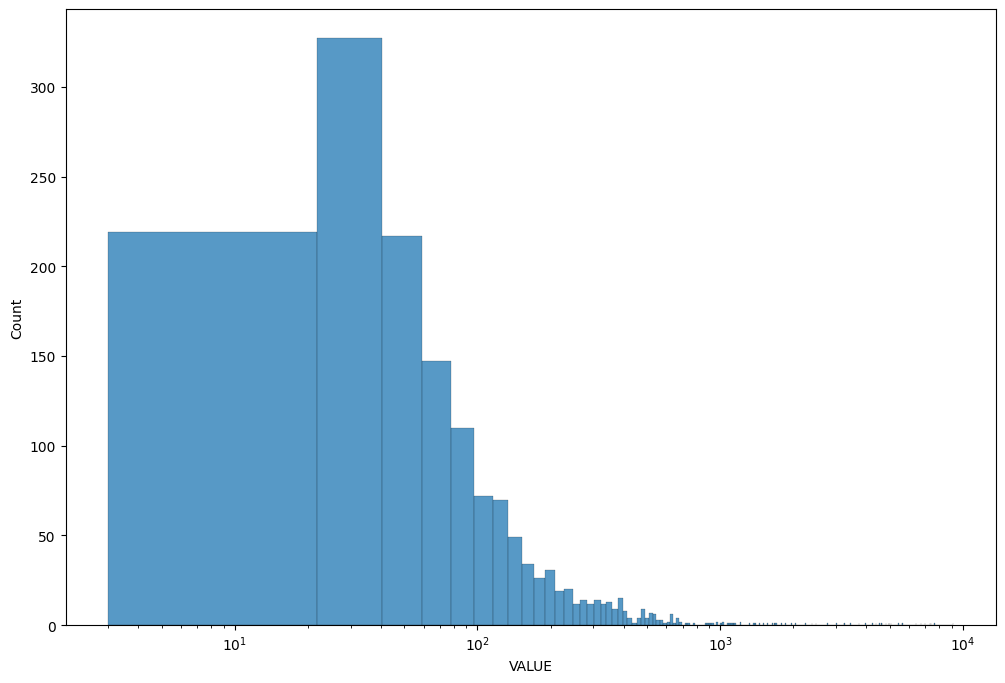

In [132]:
hp = sns.histplot(data=df_ie_ndq5_cleaned, x='VALUE')
hp.set_xscale('log')
plt.show()

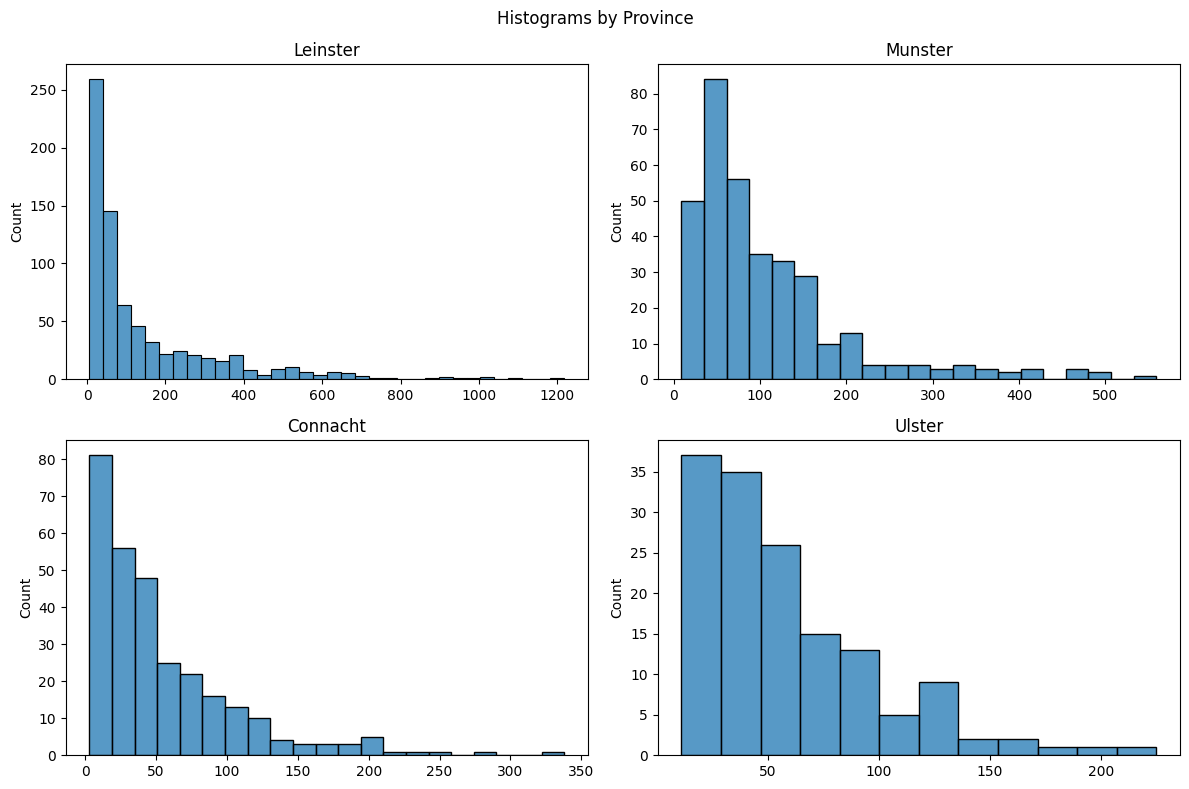

In [140]:
# Create figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Create histograms
sns.histplot(data=df_ie_ndq5_cleaned[df_ie_ndq5_cleaned['province']=='Leinster'], x="VALUE", kde=False, ax=axs[0, 0])
sns.histplot(data=df_ie_ndq5_cleaned[df_ie_ndq5_cleaned['province']=='Munster'], x="VALUE", kde=False, ax=axs[0, 1])
sns.histplot(data=df_ie_ndq5_cleaned[df_ie_ndq5_cleaned['province']=='Connacht'], x="VALUE", kde=False, ax=axs[1, 0])
sns.histplot(data=df_ie_ndq5_cleaned[df_ie_ndq5_cleaned['province']=='Ulster'], x="VALUE", kde=False, ax=axs[1, 1])

# Set titles and axis labels
axs[0, 0].set_title("Leinster")
axs[0, 1].set_title("Munster")
axs[1, 0].set_title("Connacht")
axs[1, 1].set_title("Ulster")
fig.suptitle("Histograms by Province")
for ax in axs.flat:
    ax.set(xlabel=None, ylabel="Count")

# Adjust layout
fig.tight_layout()

# Show plot
plt.show()

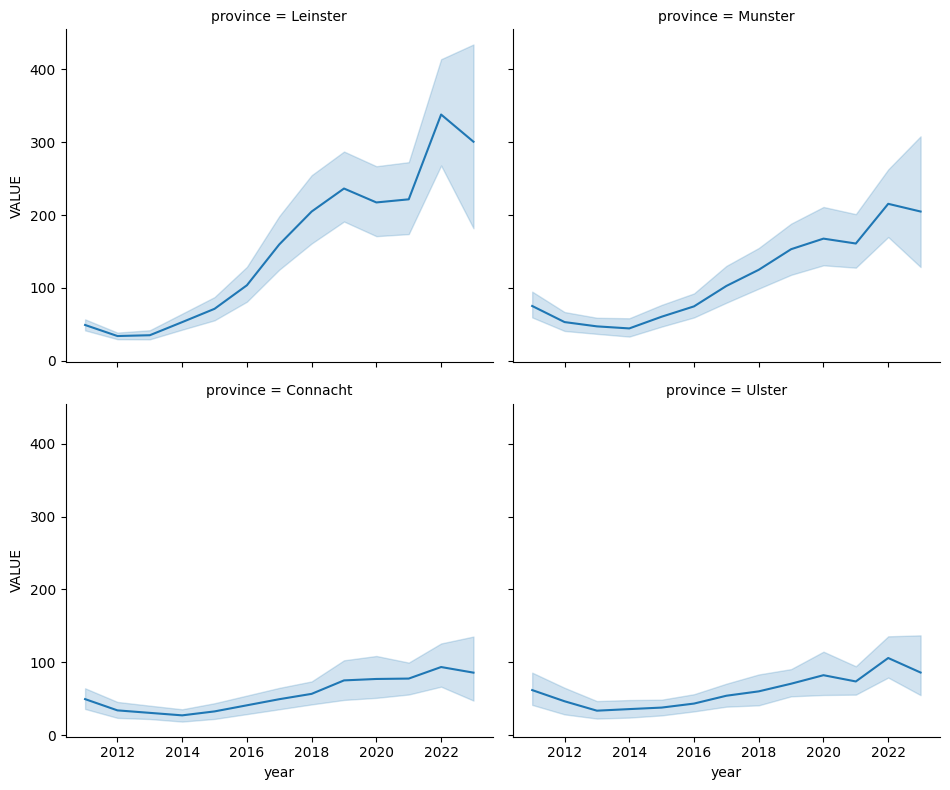

In [141]:
sns.relplot(data=df_ie_ndq5_cleaned, kind='line', x='year', y='VALUE', 
            col='province', col_wrap=2, height=4, aspect=1.2, legend=True)
plt.show()

## IE DF no.4

In [85]:
df_ie_ndq6 = deepcopy(df_ie_ndq6_orig)

In [86]:
df_ie_ndq6.head(10)

STATISTIC          STATISTIC Label  TLIST(Q1) Quarter C02342V02816  \
0     NDQ06  New Dwelling Completion      20111  2011Q1           06   
1     NDQ06  New Dwelling Completion      20111  2011Q1           06   
2     NDQ06  New Dwelling Completion      20111  2011Q1           06   
3     NDQ06  New Dwelling Completion      20111  2011Q1           06   
4     NDQ06  New Dwelling Completion      20111  2011Q1           06   
5     NDQ06  New Dwelling Completion      20111  2011Q1           06   
6     NDQ06  New Dwelling Completion      20111  2011Q1           06   
7     NDQ06  New Dwelling Completion      20111  2011Q1           06   
8     NDQ06  New Dwelling Completion      20111  2011Q1           06   
9     NDQ06  New Dwelling Completion      20111  2011Q1           06   

  Type of House                          C03789V04537  \
0  Single house  2ae19629-1434-13a3-e055-000000000001   
1  Single house  2ae19629-14a2-13a3-e055-000000000001   
2  Single house  2ae19629-149d-13a3-e055-000000000001   
3  Single house  2ae19629-14a3-13a3-e055-000000000001   
4  Single house  2ae19629-1492-13a3-e055-000000000001   
5  Single house  2ae19629-1433-13a3-e055-000000000001   
6  Single house  2ae19629-149f-13a3-e055-000000000001   
7  Single house  2ae19629-14a4-13a3-e055-000000000001   
8  Single house  2ae19629-14a0-13a3-e055-000000000001   
9  Single house  2ae19629-14a5-13a3-e055-000000000001   

                         Local Authority    UNIT  VALUE  
0                      Cork City Council  Number      8  
1                   Clare County Council  Number     45  
2                   Cavan County Council  Number     21  
3                    Cork County Council  Number    145  
4                  Carlow County Council  Number     17  
5                    Dublin City Council  Number      6  
6  Dún Laoghaire Rathdown County Council  Number     16  
7                 Donegal County Council  Number     82  
8                  Fingal County Council  Number     17  
9                  Galway County Council  Number     92

In [87]:
df_ie_ndq6 = extract_year_and_qtr(df_ie_ndq6, 'Quarter')

In [88]:
# From previous cleaning we know that C02342V02816 & C03789V04537 map to type of house & local authority.
list_cols_to_drop = ['STATISTIC', 'TLIST(Q1)', 'C02342V02816', 'C03789V04537', 'UNIT']
df_ie_ndq6 = df_ie_ndq6.drop(list_cols_to_drop, axis=1)

In [89]:
df_ie_ndq6.head(10)

STATISTIC Label Quarter Type of House  \
0  New Dwelling Completion  2011Q1  Single house   
1  New Dwelling Completion  2011Q1  Single house   
2  New Dwelling Completion  2011Q1  Single house   
3  New Dwelling Completion  2011Q1  Single house   
4  New Dwelling Completion  2011Q1  Single house   
5  New Dwelling Completion  2011Q1  Single house   
6  New Dwelling Completion  2011Q1  Single house   
7  New Dwelling Completion  2011Q1  Single house   
8  New Dwelling Completion  2011Q1  Single house   
9  New Dwelling Completion  2011Q1  Single house   

                         Local Authority  VALUE  year qtr  
0                      Cork City Council      8  2011  Q1  
1                   Clare County Council     45  2011  Q1  
2                   Cavan County Council     21  2011  Q1  
3                    Cork County Council    145  2011  Q1  
4                  Carlow County Council     17  2011  Q1  
5                    Dublin City Council      6  2011  Q1  
6  Dún Laoghaire Rathdown County Council     16  2011  Q1  
7                 Donegal County Council     82  2011  Q1  
8                  Fingal County Council     17  2011  Q1  
9                  Galway County Council     92  2011  Q1

In [120]:
df_ie_ndq6.describe(include='all')

STATISTIC Label Quarter Type of House    Local Authority  \
count                      6272    6272          6272               6272   
unique                        1      49             4                 32   
top     New Dwelling Completion  2011Q1  Single house  Cork City Council   
freq                       6272     128          1568                196   
mean                        NaN     NaN           NaN                NaN   
std                         NaN     NaN           NaN                NaN   
min                         NaN     NaN           NaN                NaN   
25%                         NaN     NaN           NaN                NaN   
50%                         NaN     NaN           NaN                NaN   
75%                         NaN     NaN           NaN                NaN   
max                         NaN     NaN           NaN                NaN   

              VALUE         year   qtr CC_name  county auth_comp  
count   6272.000000  6272.000000  6272    6272    6272      6272  
unique          NaN          NaN     4      30      27         2  
top             NaN          NaN    Q1    Cork  Dublin        CC  
freq            NaN          NaN  1664     392     784      6076  
mean     108.416454  2016.632653   NaN     NaN     NaN       NaN  
std      430.696441     3.538377   NaN     NaN     NaN       NaN  
min        0.000000  2011.000000   NaN     NaN     NaN       NaN  
25%        6.000000  2014.000000   NaN     NaN     NaN       NaN  
50%       24.000000  2017.000000   NaN     NaN     NaN       NaN  
75%       64.000000  2020.000000   NaN     NaN     NaN       NaN  
max     9143.000000  2023.000000   NaN     NaN     NaN       NaN

In [115]:
df_ie_ndq6['auth_comp'] = df_ie_ndq6['Local Authority'].apply(lambda x: 'CC' if x != "Ireland" else x)

In [116]:
df_ie_ndq6.head()

STATISTIC Label Quarter Type of House        Local Authority  \
0  New Dwelling Completion  2011Q1  Single house      Cork City Council   
1  New Dwelling Completion  2011Q1  Single house   Clare County Council   
2  New Dwelling Completion  2011Q1  Single house   Cavan County Council   
3  New Dwelling Completion  2011Q1  Single house    Cork County Council   
4  New Dwelling Completion  2011Q1  Single house  Carlow County Council   

   VALUE  year qtr CC_name  county auth_comp  
0      8  2011  Q1    Cork    Cork        CC  
1     45  2011  Q1   Clare   Clare        CC  
2     21  2011  Q1   Cavan   Cavan        CC  
3    145  2011  Q1    Cork    Cork        CC  
4     17  2011  Q1  Carlow  Carlow        CC

Duplication for fields Type of House & Local Authority.

In [123]:
ndq6_total = df_ie_ndq6[(df_ie_ndq6['auth_comp']=='CC') & (df_ie_ndq6['Type of House']=='All house types')]['VALUE'].sum()

In [125]:
print(f"NDQ1: {ndq1_total}, NDQ3: {ndq3_total}, NDQ5: {ndq5_total}, NDQ6: {ndq6_total}")
print(ndq1_total - ndq6_total)

NDQ1: 169997, NDQ3: 169985, NDQ5: 169997, NDQ6: 169997
0


In [90]:
df_ie_ndq6_cleaned = county_mapping(df_ie_ndq6, dict_county_mapping)

/var/folders/0h/ts80_9s97vn5dhtr13mj73x40000gp/T/ipykernel_29282/2775481300.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_county_province_mapping.loc[:,'County'] = df_county_province_mapping['County'].str.replace("\[[A-Za-z]\]", "", regex=True)
/var/folders/0h/ts80_9s97vn5dhtr13mj73x40000gp/T/ipykernel_29282/2775481300.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_county_province_mapping.loc[:,'County'] = df_county_province_mapping['County'].str.replace("Londonderry", "Derry")


In [91]:
df_ie_ndq6_cleaned.head(10)

STATISTIC Label Quarter    Type of House  year qtr   county  VALUE  \
0  New Dwelling Completion  2011Q1  All house types  2011  Q1   Carlow     17   
1  New Dwelling Completion  2011Q1  All house types  2011  Q1    Cavan     61   
2  New Dwelling Completion  2011Q1  All house types  2011  Q1    Clare     52   
3  New Dwelling Completion  2011Q1  All house types  2011  Q1     Cork    207   
4  New Dwelling Completion  2011Q1  All house types  2011  Q1  Donegal    118   
5  New Dwelling Completion  2011Q1  All house types  2011  Q1   Dublin    287   
6  New Dwelling Completion  2011Q1  All house types  2011  Q1   Galway    108   
7  New Dwelling Completion  2011Q1  All house types  2011  Q1  Ireland   1875   
8  New Dwelling Completion  2011Q1  All house types  2011  Q1    Kerry     62   
9  New Dwelling Completion  2011Q1  All house types  2011  Q1  Kildare    126   

   province  
0  Leinster  
1    Ulster  
2   Munster  
3   Munster  
4    Ulster  
5  Leinster  
6  Connacht  
7       NaN  
8   Munster  
9  Leinster

In [92]:
assert(df_ie_ndq6_cleaned['VALUE'].sum() == df_ie_ndq6_orig['VALUE'].sum())

In [142]:
df_ie_ndq6_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5292 entries, 0 to 5291
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   STATISTIC Label  5292 non-null   object
 1   Quarter          5292 non-null   object
 2   Type of House    5292 non-null   object
 3   year             5292 non-null   int64 
 4   qtr              5292 non-null   object
 5   county           5292 non-null   object
 6   VALUE            5292 non-null   int64 
 7   province         5096 non-null   object
dtypes: int64(2), object(6)
memory usage: 372.1+ KB


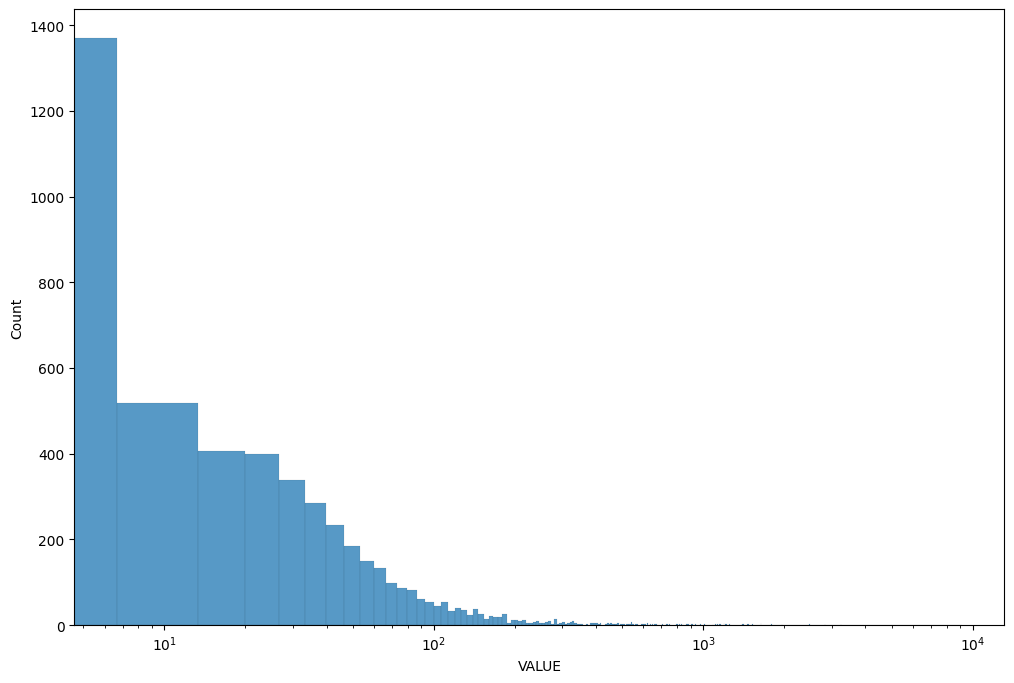

In [143]:
hp = sns.histplot(data=df_ie_ndq6_cleaned, x='VALUE')
hp.set_xscale('log')
plt.show()

In [145]:
df_ie_ndq6_cleaned['VALUE'].min()

0

In [146]:
df_ie_ndq6_cleaned[df_ie_ndq6_cleaned['VALUE']==0]

STATISTIC Label Quarter Type of House  year qtr    county  \
27    New Dwelling Completion  2011Q1     Apartment  2011  Q1    Carlow   
38    New Dwelling Completion  2011Q1     Apartment  2011  Q1     Laois   
41    New Dwelling Completion  2011Q1     Apartment  2011  Q1  Longford   
42    New Dwelling Completion  2011Q1     Apartment  2011  Q1     Louth   
43    New Dwelling Completion  2011Q1     Apartment  2011  Q1      Mayo   
...                       ...     ...           ...   ...  ..       ...   
5013  New Dwelling Completion  2022Q3     Apartment  2022  Q3  Monaghan   
5105  New Dwelling Completion  2022Q4     Apartment  2022  Q4     Clare   
5115  New Dwelling Completion  2022Q4     Apartment  2022  Q4   Leitrim   
5124  New Dwelling Completion  2022Q4     Apartment  2022  Q4     Sligo   
5211  New Dwelling Completion  2023Q1     Apartment  2023  Q1    Carlow   

      VALUE  province  
27        0  Leinster  
38        0  Leinster  
41        0  Leinster  
42        0  Leinster  
43        0  Connacht  
...     ...       ...  
5013      0    Ulster  
5105      0   Munster  
5115      0  Connacht  
5124      0  Connacht  
5211      0  Leinster  

[547 rows x 8 columns]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 547 entries, 27 to 5211
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   STATISTIC Label  547 non-null    object
 1   Quarter          547 non-null    object
 2   Type of House    547 non-null    object
 3   year             547 non-null    int64 
 4   qtr              547 non-null    object
 5   county           547 non-null    object
 6   VALUE            547 non-null    int64 
 7   province         547 non-null    object
dtypes: int64(2), object(6)
memory usage: 38.5+ KB
None


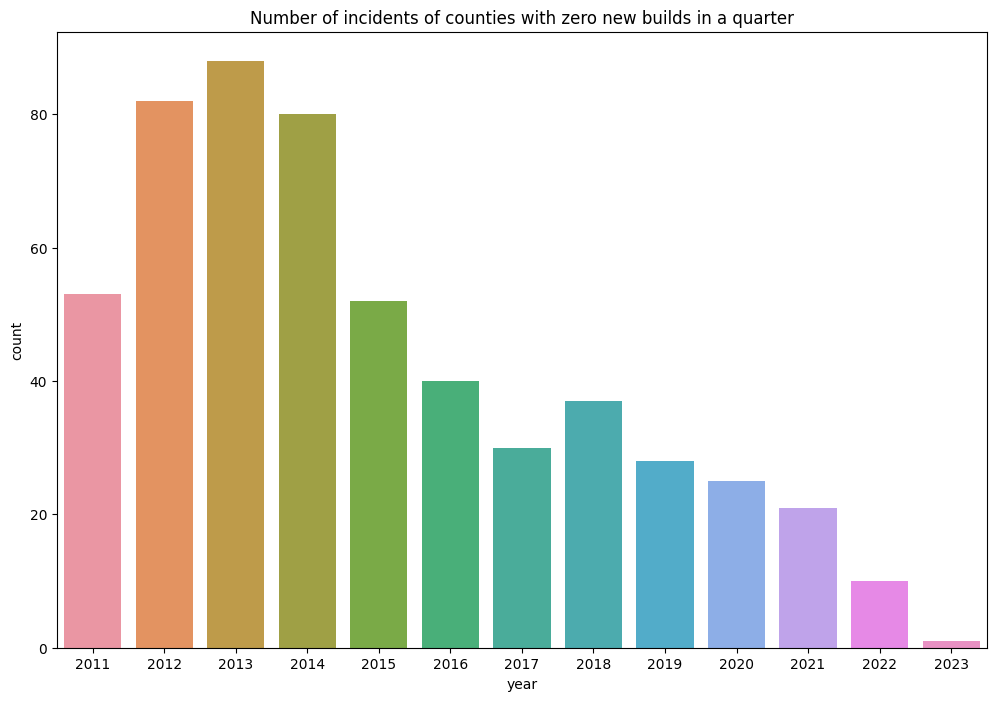

In [147]:
zero_new = df_ie_ndq6_cleaned[df_ie_ndq6_cleaned['VALUE']==0]
print(zero_new.info())
z_plot = sns.countplot(data=zero_new, x='year')
z_plot.set_title('Number of incidents of counties with zero new builds in a quarter')
plt.show()

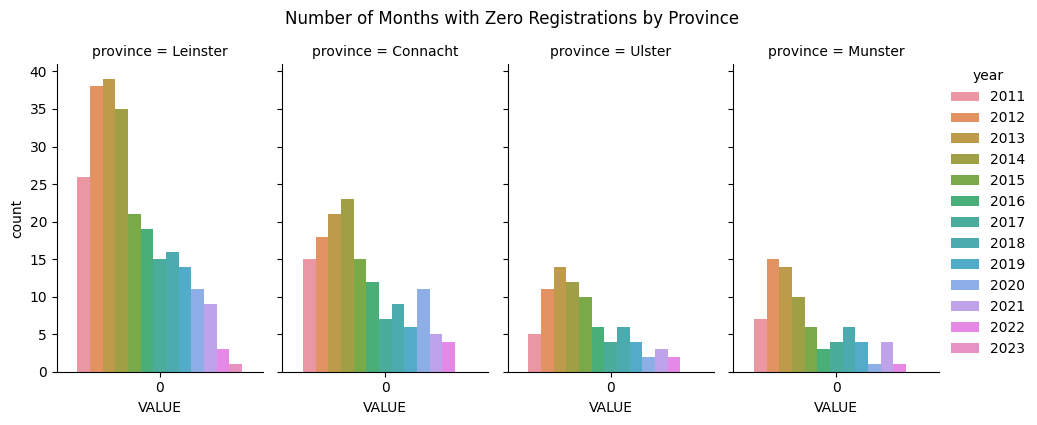

In [149]:
cp = sns.catplot(
    data=zero_new, x="VALUE", col="province", hue='year',
    kind="count", height=4, aspect=0.6
)
cp.fig.suptitle('Number of Months with Zero Registrations by Province', y=1.05)
plt.show()

## Joining together the IE dataset

In [ ]:
df_ie_final = df_ie_ndq1_clean

# DF UK

# Check which sheet to read from the spreadsheet.

In [93]:
df_uk_con_output = deepcopy(df_uk_con_output_orig)

In [94]:
df_uk_con_output_orig.head(50)

Contents  \
0                         Metadata   
1    Quarterly (from Jan-Mar 1978)   
2        Table 1a - United Kingdom   
3               Table 1b - England   
4                 Table 1c - Wales   
5              Table 1d - Scotland   
6      Table 1e - Northern Ireland   
7         Table 1f - Great Britain   
8    Financial year (from 1969-70)   
9        Table 2a - United Kingdom   
10              Table 2b - England   
11                Table 2c - Wales   
12             Table 2d - Scotland   
13     Table 2e - Northern Ireland   
14       Calendar year (from 1946)   
15       Table 3a - United Kingdom   
16              Table 3b - England   
17                Table 3c - Wales   
18             Table 3d - Scotland   
19     Table 3e - Northern Ireland   
20                 Contact Details   
21                     Tim Pateman   
22  Office for National Statistics   
23          better.info@ons.gov.uk   
24  Telephone: +44 (0)1329 44 4783   

                                           Unnamed: 1  
0        Information on the UK house building dataset  
1                                                 NaN  
2   House building: permanent dwellings started an...  
3   House building: permanent dwellings started an...  
4   House building: permanent dwellings started an...  
5   House building: permanent dwellings started an...  
6   House building: permanent dwellings started an...  
7   House building: permanent dwellings started an...  
8                                                 NaN  
9   House building: permanent dwellings started an...  
10  House building: permanent dwellings started an...  
11  House building: permanent dwellings started an...  
12  House building: permanent dwellings started an...  
13  House building: permanent dwellings started an...  
14                                                NaN  
15  House building: permanent dwellings completed,...  
16  House building: permanent dwellings started an...  
17  House building: permanent dwellings completed,...  
18  House building: permanent dwellings completed,...  
19  House building: permanent dwellings completed,...  
20                                                NaN  
21                                                NaN  
22                                                NaN  
23                                                NaN  
24                                                NaN

In [95]:
df_uk_con_england = pd.read_excel('./datasets/uk/outputukhousebuilding.xlsx', sheet_name='1b', header=5)
df_uk_con_wales = pd.read_excel('./datasets/uk/outputukhousebuilding.xlsx', sheet_name='1c', header=5)
df_uk_con_scotland = pd.read_excel('./datasets/uk/outputukhousebuilding.xlsx', sheet_name='1d', header=5)
df_uk_con_ni = pd.read_excel('./datasets/uk/outputukhousebuilding.xlsx', sheet_name='1e', header=5)

In [96]:
df_uk_con_england.head(10)

Revised          Period  Started - All Dwellings  \
0     NaN  Jan - Mar 1978                    45700   
1     NaN  Apr - Jun 1978                    69520   
2     NaN  Jul - Sep 1978                    59340   
3     NaN  Oct - Dec 1978                    52130   
4     NaN  Jan - Mar 1979                    31960   
5     NaN  Apr - Jun 1979                    54080   
6     NaN  Jul - Sep 1979                    52850   
7     NaN  Oct - Dec 1979                    51690   
8     NaN  Jan - Mar 1980                    33160   
9     NaN  Apr - Jun 1980                    38710   

   Started - Private Enterprise  Started - Housing Associations  \
0                         25880                            4460   
1                         39760                            4810   
2                         34490                            4590   
3                         33450                            4100   
4                         19060                            3220   
5                         33300                            4130   
6                         34260                            3200   
7                         34510                            3690   
8                         20470                            3140   
9                         25210                            3490   

  Started - Local Authorities  Completed - All Dwellings  \
0                       15360                      57360   
1                       24950                      61450   
2                       20270                      59160   
3                       14580                      63340   
4                        9680                      43380   
5                       16650                      48790   
6                       15380                      47160   
7                       13480                      70130   
8                        9560                      49600   
9                       10010                      49400   

   Completed - Private Enterprise  Completed - Housing Associations  \
0                           30230                              4840   
1                           32930                              4980   
2                           30620                              5260   
3                           33660                              5480   
4                           24810                              4160   
5                           27840                              3450   
6                           26130                              3490   
7                           39600                              5180   
8                           27730                              4550   
9                           26250                              4950   

  Completed - Local Authorities  
0                         22290  
1                         23540  
2                         23280  
3                         24200  
4                         14410  
5                         17490  
6                         17540  
7                         25350  
8                         17320  
9                         18200

In [97]:
df_uk_con_england = df_uk_con_england.drop(['Revised'], axis=1)

In [98]:
df_uk_con_england['year'] = df_uk_con_england['Period'].str[-4:]
df_uk_con_england['time_period'] = df_uk_con_england['Period'].str[:-4]

In [99]:
dict_quarter_mapping = {"Jan - Mar": "Q1", "Apr - Jun": "Q2", "Jul - Sep": "Q3", "Oct - Dec": "Q4"}

In [100]:
df_uk_con_england['quarter'] = df_uk_con_england['time_period'].str.strip().replace(dict_quarter_mapping)
df_uk_con_england['yr_qtr'] = df_uk_con_england['year'] + df_uk_con_england['quarter']

In [101]:
list_cols_to_drop = [col for col in df_uk_con_england.columns if "Started" in str(col)]

In [102]:
list_cols_to_drop.extend(['Period', 'time_period'])

In [103]:
df_uk_con_england = df_uk_con_england.drop(list_cols_to_drop, axis=1)

In [104]:
df_uk_con_england.head()

Completed - All Dwellings  Completed - Private Enterprise  \
0                      57360                           30230   
1                      61450                           32930   
2                      59160                           30620   
3                      63340                           33660   
4                      43380                           24810   

   Completed - Housing Associations Completed - Local Authorities  year  \
0                              4840                         22290  1978   
1                              4980                         23540  1978   
2                              5260                         23280  1978   
3                              5480                         24200  1978   
4                              4160                         14410  1979   

  quarter  yr_qtr  
0      Q1  1978Q1  
1      Q2  1978Q2  
2      Q3  1978Q3  
3      Q4  1978Q4  
4      Q1  1979Q1

In [105]:
df_uk_con_england.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Completed - All Dwellings         179 non-null    int64 
 1   Completed - Private Enterprise    179 non-null    int64 
 2   Completed - Housing Associations  179 non-null    int64 
 3   Completed - Local Authorities     179 non-null    object
 4   year                              179 non-null    object
 5   quarter                           179 non-null    object
 6   yr_qtr                            179 non-null    object
dtypes: int64(3), object(4)
memory usage: 9.9+ KB


In [106]:
def prepare_uk_df(df, qtr_dict):
    """
    
    ADD DOCSTRING
    
    """
    df['year'] = df['Period'].str[-4:]
    df['time_period'] = df['Period'].str[:-4]
    df['quarter'] = df['time_period'].str.strip().replace(qtr_dict)
    df['yr_qtr'] = df['year'] + df['quarter']
    list_cols_to_drop = [col for col in df.columns if "Started" in str(col)]
    list_cols_to_drop.extend(['Revised', 'Period', 'time_period'])
    df = df.drop(list_cols_to_drop, axis=1)
    return df

In [107]:
df_uk_con_wales = prepare_uk_df(df_uk_con_wales, dict_quarter_mapping)
df_uk_con_scotland = prepare_uk_df(df_uk_con_scotland, dict_quarter_mapping)
df_uk_con_ni = prepare_uk_df(df_uk_con_ni, dict_quarter_mapping)

# DF Population

In [108]:
# https://data.worldbank.org/indicator/SP.POP.TOTL
# Load the XML file
pop_files = glob.glob('./datasets/pop/*.xml')

In [109]:
try:
    with open(pop_files[0], 'r') as file:

        # Print the first 5 lines of the file
        for i in range(20):
            print(file.readline())
except exception as e:
    print('Error: ' + e)
finally:
        file.close()

﻿<?xml version="1.0" encoding="utf-8"?>

<Root xmlns:wb="http://www.worldbank.org">

  <data>

    <record>

      <field name="Country or Area" key="ABW">Aruba</field>

      <field name="Item" key="SP.POP.TOTL">Population, total</field>

      <field name="Year">1960</field>

      <field name="Value">54608</field>

    </record>

    <record>

      <field name="Country or Area" key="ABW">Aruba</field>

      <field name="Item" key="SP.POP.TOTL">Population, total</field>

      <field name="Year">1961</field>

      <field name="Value">55811</field>

    </record>

    <record>

      <field name="Country or Area" key="ABW">Aruba</field>

      <field name="Item" key="SP.POP.TOTL">Population, total</field>

      <field name="Year">1962</field>

      <field name="Value">56682</field>



In [110]:
tree = ET.parse(pop_files[0])

# Get the root element of the XML file
root = tree.getroot()

# List to store the parsed xml data before converting to a dataframe
data_list = []

# Loop through the records and append each row of data to the list as a dictionary
# Where the
for record in root.findall('data/record'):
    data_dict = {}
    for field in record.findall('field'):
#         if field.get('name') == 'Item':
#             continue
        name = field.get('name')
        value = field.text
        data_dict[name] = value
    data_list.append(data_dict)

In [111]:
# Create a DataFrame from the list
df_global_population = pd.DataFrame(data_list)

In [112]:
# Print the DataFrame
print(df_global_population['Item'].unique())

['Population, total']


In [113]:
df_global_population.head()

Country or Area               Item  Year  Value
0           Aruba  Population, total  1960  54608
1           Aruba  Population, total  1961  55811
2           Aruba  Population, total  1962  56682
3           Aruba  Population, total  1963  57475
4           Aruba  Population, total  1964  58178

In [114]:
df_global_population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16492 entries, 0 to 16491
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Country or Area  16492 non-null  object
 1   Item             16492 non-null  object
 2   Year             16492 non-null  object
 3   Value            16400 non-null  object
dtypes: object(4)
memory usage: 515.5+ KB
